# <div align="center"> Part 3 : Extracting historical stock prices and combining the tweets information</div>

# Table of Content
###  1 . [Historical Stock Prices](#sec1)
> #### 1.1 . [Introduction to Google Finance](#sec1.1)
> #### 1.2 . [Extract Stock Data](#sec1.2)
> #### 1.3 . [Data Preparation for Machine Learning Algorithm](#sec1.2)

###  2 . [Graphlab](#sec2)
> #### 2.1 . [Introduction to Graphlab](#sec2.1)
> #### 2.2 . [Advantages of Graphlab](#sec2.2)
> #### 2.3 . [Machine Learning with Graphlab](#sec2.3)
>> ##### 2.3.1 . [Load libraries](#sec2.3.1)
>> ##### 2.3.2 . [Load data](#sec2.3.2)
>> ##### 2.3.3 . [Model building with Machine Learning algorithm](#sec2.3.3)
>> ##### 2.3.4 . [Model output with Graphlab](#sec2.3.4)
>> ##### 2.3.5 . [Model output with Plotly](#sec2.3.5)

###  3 . [References](#sec3)
> #### 3.1 . [Historical Stock Prices](#sec3.1)
> #### 3.2 . [Graphlab](#sec3.2)

<a id='sec1'></a>
## 1. Historical Stock Prices

<a id='sec1.1'></a>
### 1.1 Introduction to Google Finance

<p>There are various APIs that enable extraction of stock prices such as FinancialContent, Yahoo, Google, Investopedia, Quotemedia, MSN, FinData, etc. But for the purpose of our analysis, we needed the stock prices at minute level. GoogleFinance was easier in that aspect compared to the rest of them. </p>

<p>Google Finance is a website launched by Google. It provides stock information on many corporations that are publicly listed. It also provides headlines on financial decisions pertaining to the corporations.</p> 

<a id='sec1.2'></a>
### 1.2 Extract Stock Data

<p>The below code is used to get the stock prices for a company at minute level. Run this part of the code without any changes.<p>

In [3]:
import urllib,time,datetime

class Quote(object):
  
    DATE_FMT = '%Y-%m-%d'
    TIME_FMT = '%H:%M:%S'

    def __init__(self):
        self.symbol = ''
        self.date,self.time,self.open_,self.high,self.low,self.close,self.volume = ([] for _ in range(7))

    def append(self,dt,open_,high,low,close,volume):
        self.date.append(dt.date())
        self.time.append(dt.time())
        self.open_.append(float(open_))
        self.high.append(float(high))
        self.low.append(float(low))
        self.close.append(float(close))
        self.volume.append(int(volume))

    def to_csv(self):
        return ''.join(["{0},{1},{2},{3:.2f},{4:.2f},{5:.2f},{6:.2f},{7}\n".format(self.symbol,
              self.date[bar].strftime('%Y-%m-%d'),self.time[bar].strftime('%H:%M:%S'),
              self.open_[bar],self.high[bar],self.low[bar],self.close[bar],self.volume[bar]) 
              for bar in xrange(len(self.close))])

    def write_csv(self,filename):
    with open(filename,'w') as f:
          f.write(self.to_csv())

    def read_csv(self,filename):
    self.symbol = ''
    self.date,self.time,self.open_,self.high,self.low,self.close,self.volume = ([] for _ in range(7))
    for line in open(filename,'r'):
        symbol,ds,ts,open_,high,low,close,volume = line.rstrip().split(',')
        self.symbol = symbol
        dt = datetime.datetime.strptime(ds+' '+ts,self.DATE_FMT+' '+self.TIME_FMT)
        self.append(dt,open_,high,low,close,volume)
    return True

    def __repr__(self):
        return self.to_csv()

class GoogleIntradayQuote(Quote):
    def __init__(self,symbol,interval_seconds=60,num_days=10):
    super(GoogleIntradayQuote,self).__init__()
    self.symbol = symbol.upper()
    url_string = "http://www.google.com/finance/getprices?q={0}".format(self.symbol)
    url_string += "&i={0}&p={1}d&f=d,o,h,l,c,v".format(interval_seconds,num_days)
    csv = urllib.urlopen(url_string).readlines()
    for bar in xrange(7,len(csv)):
        if csv[bar].count(',')!=5: continue
        offset,close,high,low,open_,volume = csv[bar].split(',')
        if offset[0]=='a':
            day = float(offset[1:])
            offset = 0
        else:
            offset = float(offset)
        open_,high,low,close = [float(x) for x in [open_,high,low,close]]
        dt = datetime.datetime.fromtimestamp(day+(interval_seconds*offset))
        self.append(dt,open_,high,low,close,volume) 

<p> The above part creates classes and objects to connect to Google Finance, extract data at the level specified and saves it in a csv file. To get the historical stock prices for a company, say Target, run the below code with it's name as listed and interval between the records. Here we want data at minute level, so the interval is 60, which means 60 seconds.<p> 

In [ ]:
if __name__ == '__main__':
    q = GoogleIntradayQuote('TGT',60,10)
    q.write_csv('target_stock.csv')

<p>This creates a csv file by the name specified at the location where the code is saved and run from.<p>

<a id='sec1.3'></a>
### 1.3 Data Preparation for Machine Learning Algorithm

<p>The data thus extracted from Google Finance is then merged with the sentiment score calculated at minute level with the tweets drawn from twitter for the company at minute level.

The merged dataset has the following columns,

<ul>
    <li>Date, Time (in minute intervals)</li> 
    <li>Open, High, Low and Close Prices for the company</li>
    <li>Volume shares for the company</li>
    <li>Sentiment scores - Positive, negative, neutral and complete scores</li>
</ul>

<p>To account for the sentiment scores that are not available for every minute, an average of the last 5 minutes of the sentiment score of imputed in cases of missing values.

Also the price and sentiment additional features or attributes are created in order to hold the average of last 2 minutes, 3 minutes, 4 minutes and 5 minutes prices and sentiment scores.

The final dataset will thus hold the following columns,<p>

<ul>
    <li>Date, Time (in minute intervals)</li> 
    <li>Open, High, Low and Close Prices for the company</li>
    <li>Volume shares for the company</li>
    <li>Imputed Sentiment scores - Positive, negative, neutral and complete scores - no missing values</li>
    <li>Average Prices - last 2 minutes, last 3 minutes, last 4 minutes and last 5 minutes</li>
    <li>Average Sentiment Scores - last 2 minutes, last 3 minutes, last 4 minutes and last 5 minutes</li>
</ul>


# <div align="center"> Part 4 : Using graphlab to train and test the regression model</div>

<a id='sec2'></a>
## 2. Graphlab

<a id='sec2.1'></a>
### 2.1 Introduction to Graphlab

<p>GraphLab Create is an extensible machine learning framework that enables developers and data scientists to easily build and deploy intelligent applications and services at scale. It includes distributed data structures and rich libraries for data transformation and manipulation, scalable task-oriented machine learning toolkits for creating, evaluating, and improving machine learning models, data and model visualization for all aspects of development, and a client to define and deploy both distributed batch jobs to Turi Distributed as well as real-time machine learning services to Turi Predictive Service. It is designed for end-to-end developer productivity, scale, and the variety and complexity of real-world data.<p>

<p>Turi is a graph-based, high performance, distributed computation framework written in C++. The GraphLab project was started by Prof. Carlos Guestrin of Carnegie Mellon University in 2009. It is an open source project using an Apache License. While GraphLab was originally developed for Machine Learning tasks, it has found great success at a broad range of other data-mining tasks; out-performing other abstractions by orders of magnitude.<p>

<p>Main features of GraphLab are:<p>
<ul>
    <li>A unified multicore and distributed API: write once run efficiently in both shared and distributed memory systems</li>
    <li>Tuned for performance: optimized C++ execution engine leverages extensive multi-threading and asynchronous IO</li>
    <li>Scalable: GraphLab intelligently places data and computation using sophisticated new algorithms</li>
    <li>HDFS Integration</li>
    <li>Powerful Machine Learning Toolkits</li>
</ul>

<a id='sec2.2'></a>
### 2.2 Advantages of Graphlab

As the amounts of collected data and computing power grows (multicore, GPUs, clusters, clouds), modern datasets no longer fit into one computing node. Efficient distributed/parallel algorithms for handling large scale data are required. The GraphLab framework is a parallel programming abstraction targeted for sparse iterative graph algorithms. GraphLab provides a high level programming interface, allowing a rapid deployment of distributed machine learning algorithms. 

<p>The main design considerations behind the design of GraphLab are:<p>
<ul>
    <li>Sparse data with local dependencies</li>
    <li>Iterative algorithms</li>
    <li>Potentially asynchronous execution</li>
</ul>

<p>The major advantages of GraphLab include:<p>
<ul>
    <li><i>Create Sophisticated Models</i> - Includes implementations for deep learning, ranking-optimized factorization machines, topic modeling, graph analytics, linear models, clustering, and nearest neighbors. Then go as deep as you need, tuning exposed hyperparameters to customize your models.</li>
    
    <li><i>Scaling</i> - Interact with terabytes of data, blazingly fast, even on a laptop. SFrame, the out of core tabular data structure is columnar, distributed, and on-disk making is the most scalable data frame built for machine learning.</li>
    
    <li><i>Deployment</i> - Deployment clients for Turi Predictive Services and Distributed are included. Same code deploys on remote environments as a distributed batch job or as services. Eliminate the lengthy rewrites.</li>
    
    <li><i>Visualization</i> - GraphLab Create’s visualization “Canvas” provides exploration and visualization of big data and sophisticated machine learning models. This helps to explain results easily.</li>
    
    <li><i>Extension</i> - API is extensible in multiple ways. With this can implement data parallel and graph parallel algorithms as UDFs in Python or build customized efficient algorithms using the C++ SDK. Implement your own scalable brilliance.</li>
</ul>   

<i>What can we get in Graphlab that is not in scikit-learn, R, or similar already?</i>

<p>Scikit-learn and R are great broad libraries. GraphLab Create has some of the same algorithms and functionality as these libraries. The major difference is that GraphLab Create uses the SFrame which is a highly scalable and performant data structure which makes many operations and algorithms much much faster. The SFrame is also out-of-core which means you can scale to big data even on a laptop. Beyond speed and scalability, GraphLab Create is designed around application oriented toolkits that contain the most sophisticated algorithms like factorization machines, deep learning, etc.<p>


<a id='sec2.3'></a>
### 2.3 Machine Learning with Graphlab

<a id='sec2.3.1'></a>
#### 2.3.1 Loading libraries

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import graphlab as gl
import plotly.plotly as py
import plotly.graph_objs as go
import numpy as np

<a id='sec2.3.2'></a>
#### 2.3.2 Loading data

In [4]:
url = 'C:/Users/Lavanya/Google Drive/Big Data Project/Codes/target_tweets_score_final_data.csv'
data = gl.SFrame.read_csv(url, header= True, 
                            column_type_hints={
                                 'Date': str, 'Time': str, 'Seq': int, 'SeqSq': int, 'Open': float, 'High': float, 
        'Low': float, 'Price': float, 'Volume': float, 'log_Open': float, 'log_High': float, 'log_Low': float, 
        'log_Price': float, 'log_Volume': float, 'lag_1_Price': float, 'lag_2_Price': float, 'lag_3_Price': float,
        'lag_4_Price': float, 'lag_5_Price': float, 'log_lag_1_Price': float, 'log_lag_2_Price': float, 
        'log_lag_3_Price': float, 'log_lag_4_Price': float, 'log_lag_5_Price': float, 'final_com_score': float, 
        'final_pos_score': float, 'final_neu_score': float, 'final_neg_score': float, 'lag_1_final_com_score': float, 
        'lag_1_final_pos_score': float, 'lag_1_final_neu_score': float, 'lag_1_final_neg_score': float, 
        'lag_2_final_com_score': float, 'lag_2_final_pos_score': float, 'lag_2_final_neu_score': float, 
        'lag_2_final_neg_score': float, 'lag_3_final_com_score': float, 'lag_3_final_pos_score': float, 
        'lag_3_final_neu_score': float, 'lag_3_final_neg_score': float, 'lag_4_final_com_score': float, 
        'lag_4_final_pos_score': float, 'lag_4_final_neu_score': float, 'lag_4_final_neg_score': float, 
        'lag_5_final_com_score': float, 'lag_5_final_pos_score': float, 'lag_5_final_neu_score': float,
        'lag_5_final_neg_score': float
    })

[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: C:\Users\Lavanya\AppData\Local\Temp\graphlab_server_1481497574.log.0


This non-commercial license of GraphLab Create for academic use is assigned to basav015@umn.edu and will expire on December 10, 2017.


Finished parsing file C:\Users\Lavanya\Google Drive\Big Data Project\Codes\target_tweets_score_final_data.csv

Parsing completed. Parsed 100 lines in 0.025645 secs.

Finished parsing file C:\Users\Lavanya\Google Drive\Big Data Project\Codes\target_tweets_score_final_data.csv

Parsing completed. Parsed 1558 lines in 0.024067 secs.

<a id='sec2.3.3'></a>
#### 2.3.3 Model building with Machine Learning algorithm

In [5]:
model = gl.linear_regression.create(data, target='Price', features=['lag_5_Price', 'lag_5_final_com_score'])

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Linear regression:

--------------------------------------------------------

Number of examples          : 1462

Number of features          : 2

Number of unpacked features : 2

Number of coefficients    : 3

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+----------------------+---------------+-----------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Validation-max_error | Training-rmse | Validation-rmse |

+-----------+----------+--------------+--------------------+----------------------+---------------+-----------------+

| 1         | 2        | 1.007013     | 0.841045           | 0.368150             | 0.124254      | 0.134808        |

+-----------+----------+--------------+--------------------+----------------------+---------------+-----------------+

SUCCESS: Optimal solution found.

<a id='sec2.3.4'></a>
#### 2.3.4 Model output with Graphlab

Class                          : LinearRegression

Schema
------
Number of coefficients         : 3
Number of examples             : 1462
Number of feature columns      : 2
Number of unpacked features    : 2

Hyperparameters
---------------
L1 penalty                     : 0.0
L2 penalty                     : 0.01

Training Summary
----------------
Solver                         : newton
Solver iterations              : 1
Solver status                  : SUCCESS: Optimal solution found.
Training time (sec)            : 1.013

Settings
--------
Residual sum of squares        : 22.5719
Training RMSE                  : 0.1243

Highest Positive Coefficients
-----------------------------
(intercept)                    : 10.9291
lag_5_Price                    : 0.8589

Lowest Negative Coefficients
----------------------------
lag_5_final_com_score          : -0.0328



name,index,value,stderr
(intercept),None,10.9290742935,0.463025621231
lag_5_Price,None,0.858887849149,0.00599192625173
lag_5_final_com_score,None,-0.0328283304817,0.011177279447


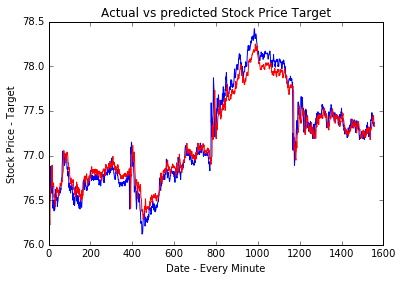

In [6]:
# Make predictions and evaluate results.
predictions = model.predict(data)
results = model.evaluate(data)
# plot
plt.plot(data['Price'], label = "Actual", color='blue', linestyle='-')
plt.plot(predictions, label = "Predictions", color='red', linestyle='-')
plt.title('Actual vs predicted Stock Price Target')
plt.ylabel('Stock Price - Target')
plt.xlabel('Date - Every Minute')
model.summary()
model['coefficients']

<a id='sec2.3.5'></a>
#### 2.3.5 Model output with Plotly

In [9]:
trace1 = go.Scatter(
            x= np.arange(1,len(data['Price'])-1),
            y= list(data['Price']),
            name = "Actual")
trace2 = go.Scatter(
            x= np.arange(1,len(predictions)),
            y= list(predictions),
            name = "Predicted")
plot_data = [trace1,trace2]

layout = go.Layout(
    title='Target Stock Price',
    xaxis=dict(title='Minute time intervals'),
    yaxis=dict(title='Stock price'))
fig = go.Figure(data=plot_data, layout=layout)
py.iplot(fig, filename='Regression-model')

<a id='sec3'></a>
## 3. References

<a id='sec3.1'></a>
### 3.1 Historical Stock Prices

<p>Below are the references used for the section on historical stock prices,</p>

<ul>
    <li><i>http://www.google.com/finance/getprices</i></li> 
    <li><i>https://en.wikipedia.org/wiki/Google_Finance</i></li>
    <li><i>https://trading.cheno.net/downloading-google-intraday-historical-data-with-python/</i></li>
</ul>

<a id='sec3.2'></a>
### 3.2 Graphlab

<p>Below are the references used for the section on Graphlab,</p>

<ul>
    <li><i>https://en.wikipedia.org/wiki/GraphLab</i></li> 
    <li><i>https://turi.com/products/create/</i></li>
    <li><i>https://turi.com/products/create/docs/graphlab.toolkits.regression.html</i></li>
</ul>